In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import random
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from collections import Counter
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [25]:
dataset_path = '/kaggle/input/young-affectnet-hq'
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [26]:
# 1. Preprocessing function (adjusted for your dataset)
def preprocess_image(img, apply_denoise=False, denoise_strength=7, apply_clahe=True, clahe_clip=2.0, apply_sharpen=True):
    """Preprocess single image for emotion recognition"""
    img = cv2.resize(img, (128, 128))  # Resize from 512x512 to 48x48
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = img.astype(np.uint8)
    
    # Optional: Noise Reduction
    if apply_denoise:
        img = cv2.fastNlMeansDenoising(
            img, None,
            h=denoise_strength,
            templateWindowSize=5,
            searchWindowSize=15
        )

    # Optional: Contrast Adjustment
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
        img = clahe.apply(img)

    # Optional: Sharpening
    if apply_sharpen:
        blurred = cv2.GaussianBlur(img, (3, 3), 1.0)
        img = cv2.addWeighted(img, 1.2, blurred, -0.2, 0)

    img = img / 255.0  # Normalization
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    
    return img

In [27]:
# 2. Dataset loading function (adjusted for your structure)
def load_dataset_and_Preprocess(base_path, emotion_list):
    X, y = [], []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(emotion_list)}
    
    for cls_name in emotion_list:
        cls_path = os.path.join(base_path, cls_name)
        for file_name in tqdm(os.listdir(cls_path), desc=f"Loading {cls_name}"):
            file_path = os.path.join(cls_path, file_name)
            img = cv2.imread(file_path)
            if img is not None:
                img = preprocess_image(img)
                X.append(img)
                y.append(class_to_idx[cls_name])
    
    return np.array(X), np.array(y), emotion_list

In [28]:
# Load dataset
X, y, class_names = load_dataset_and_Preprocess(dataset_path, emotions)

Loading surprise: 100%|██████████| 1851/1851 [00:31<00:00, 59.11it/s]


In [29]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Function to nicely print class distributions
def print_class_distribution(y, class_names, dataset_name="Dataset"):
    print(f"\n{dataset_name} class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]}: {count} images")
    print(f"Total samples: {len(y)}")

# After splitting
print_class_distribution(y_train, class_names, dataset_name="Training set")
print_class_distribution(y_test, class_names, dataset_name="Validation set")

In [30]:
# Define augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,       # Moderate rotation
    width_shift_range=0.1,  # Small shifts
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,         # Slight zoom
    horizontal_flip=True,   # Mirror images
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

In [ ]:
def augment_class(X, y, class_idx, target_samples, class_name):
    
    # Extract current class samples
    X_class = X[y == class_idx]
    num_current = len(X_class)
    num_to_generate = max(0, target_samples - num_current)  # Prevent negative values

    if num_to_generate <= 0:
        return X_class, np.full(num_current, class_idx)

    print(f"Augmenting {class_name}: {num_current} → {target_samples} (+{num_to_generate})")

    X_aug, y_aug = [], []
    
    # Generate augmented images
    for i in tqdm(range(num_to_generate), desc=f"Augmenting {class_name}"):
        # Randomly pick an original image
        img = X_class[np.random.randint(0, num_current)]
        img = img.reshape(1, 128, 128, 1)  # Reshape for datagen
        
        # Generate 1 augmented version
        for aug_img in datagen.flow(img, batch_size=1, seed=i):
            X_aug.append(aug_img[0])
            y_aug.append(class_idx)
            break  # Only take one augmentation per loop

    # Combine original and augmented
    X_combined = np.vstack([X_class, np.array(X_aug)])
    y_combined = np.hstack([np.full(num_current, class_idx), np.array(y_aug)])
    
    return X_combined, y_combined

In [32]:
# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
# Function to nicely print class distributions
def print_class_distribution(y, class_names, dataset_name="Dataset"):
    print(f"\n{dataset_name} class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]}: {count} images")
    print(f"Total samples: {len(y)}")

# After splitting
print_class_distribution(y_train, class_names, dataset_name="Training set")
print_class_distribution(y_val, class_names, dataset_name="Validation set")

In [37]:
# Define target samples (match highest class: happy with 7215)
target_samples = 1203
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Augment low-sample classes
X_train_aug = []
y_train_aug = []

for class_name, class_idx in class_to_idx.items():
    if class_name != 'neutral': 
        X_class, y_class = augment_class(X_train, y_train, class_idx, target_samples, class_name)
    else:
        X_class = X_train[y_train == class_idx]
        y_class = np.full(len(X_class), class_idx)
    X_train_aug.append(X_class)
    y_train_aug.append(y_class)

Augmenting anger: 1166 → 1203 (+37)


Augmenting anger: 100%|██████████| 37/37 [00:00<00:00, 665.32it/s]


Augmenting contempt: 1173 → 1203 (+30)


Augmenting contempt: 100%|██████████| 30/30 [00:00<00:00, 662.52it/s]


Augmenting disgust: 1114 → 1203 (+89)


Augmenting disgust: 100%|██████████| 89/89 [00:00<00:00, 639.04it/s]


Augmenting fear: 1177 → 1203 (+26)


Augmenting fear: 100%|██████████| 26/26 [00:00<00:00, 619.78it/s]


Augmenting happy: 1191 → 1203 (+12)


Augmenting happy: 100%|██████████| 12/12 [00:00<00:00, 523.88it/s]


Augmenting sad: 1165 → 1203 (+38)


Augmenting sad: 100%|██████████| 38/38 [00:00<00:00, 620.92it/s]


Augmenting surprise: 1185 → 1203 (+18)


Augmenting surprise: 100%|██████████| 18/18 [00:00<00:00, 578.23it/s]


In [38]:
# Combine all classes
X_train_aug = np.vstack(X_train_aug)
y_train_aug = np.hstack(y_train_aug)

# Verify new class distribution
print("New class distribution:", Counter(y_train_aug))

New class distribution: Counter({0: 1203, 1: 1203, 2: 1203, 3: 1203, 4: 1203, 5: 1203, 6: 1203, 7: 1203})


In [39]:
# Compute class weights (for residual imbalance or robustness)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [40]:
# Define improved CNN model
model = Sequential([
    Input(shape=(128, 128, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),

    Dense(8, activation='softmax')
])


# Compile model
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 64)      

In [41]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Convert labels to one-hot encoding
y_train_aug = to_categorical(y_train_aug, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

In [42]:
# Train model
history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/200


2025-04-28 10:31:20.092695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 19s 91ms/step - loss: 2.5096 - accuracy: 0.1973 - val_loss: 3.0602 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 2/200
151/151 [==============================] - 13s 83ms/step - loss: 2.0549 - accuracy: 0.2817 - val_loss: 3.4224 - val_accuracy: 0.1254 - lr: 0.0010
Epoch 3/200
151/151 [==============================] - 13s 84ms/step - loss: 1.9500 - accuracy: 0.3345 - val_loss: 4.3387 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 4/200
151/151 [==============================] - 12s 82ms/step - loss: 1.8266 - accuracy: 0.3760 - val_loss: 2.4965 - val_accuracy: 0.2735 - lr: 0.0010
Epoch 5/200
151/151 [==============================] - 12s 80ms/step - loss: 1.7690 - accuracy: 0.4098 - val_loss: 4.0176 - val_accuracy: 0.2129 - lr: 0.0010
Epoch 6/200
151/151 [==============================] - 12s 81ms/step - loss: 1.7066 - accuracy: 0.4275 - val_loss: 1.5988 - val_accuracy: 0.4343 - lr: 0.0010
Epoch 7/200
151/151 [==============================] - 12s 81ms/

In [43]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

92/92 [==============================] - 1s 10ms/step


In [44]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

       anger       0.48      0.34      0.40       364
    contempt       0.60      0.60      0.60       367
     disgust       0.41      0.61      0.49       348
        fear       0.51      0.38      0.43       368
       happy       0.91      0.86      0.88       373
     neutral       0.79      0.87      0.83       376
         sad       0.45      0.47      0.46       364
    surprise       0.48      0.50      0.49       370

    accuracy                           0.58      2930
   macro avg       0.58      0.58      0.57      2930
weighted avg       0.58      0.58      0.57      2930



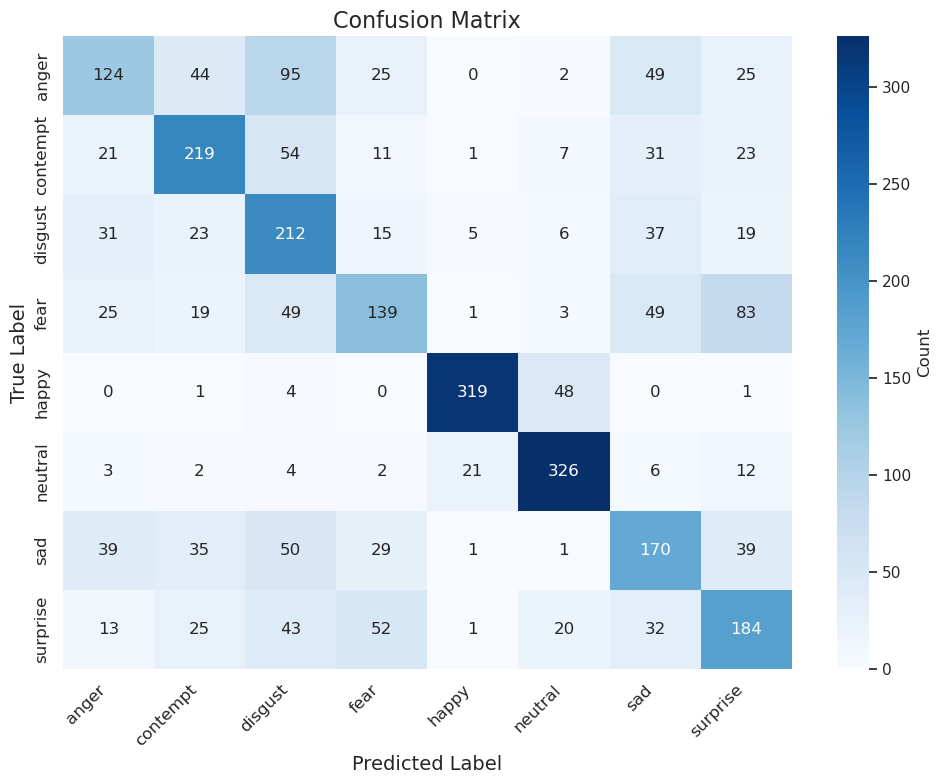

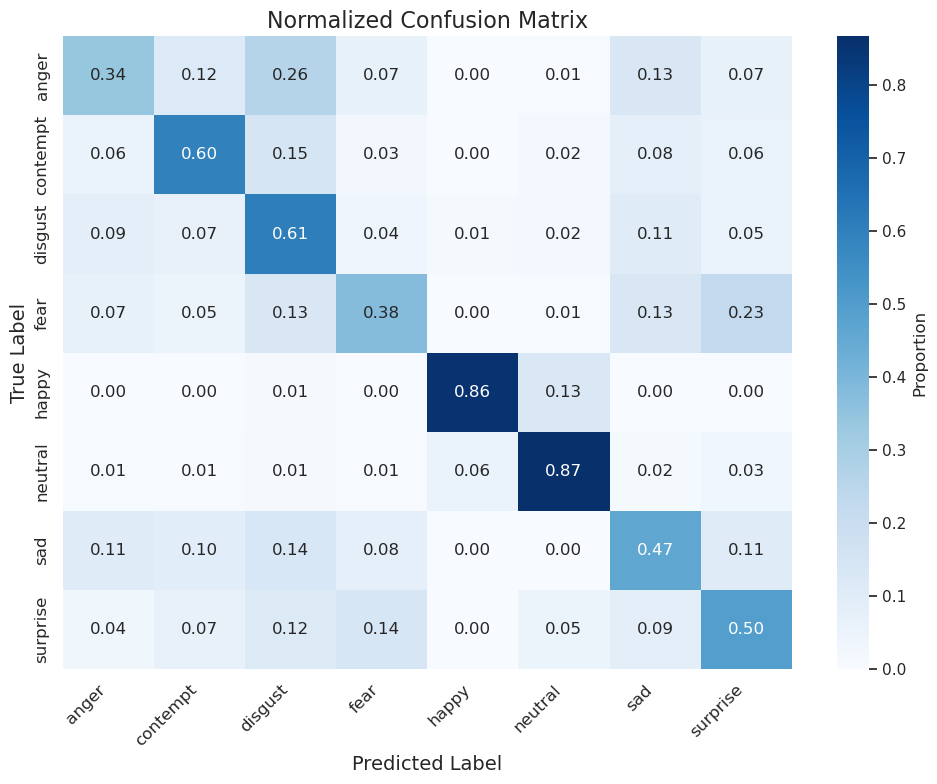

In [45]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 12},
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 12},
    cbar_kws={'label': 'Proportion'}
)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('normalized_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# One-hot encode y_test
y_test_onehot = to_categorical(y_test, num_classes=8)

# Now evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy:.4f}")

92/92 [==============================] - 1s 9ms/step - loss: 1.4534 - accuracy: 0.5778
Test Accuracy: 0.5778


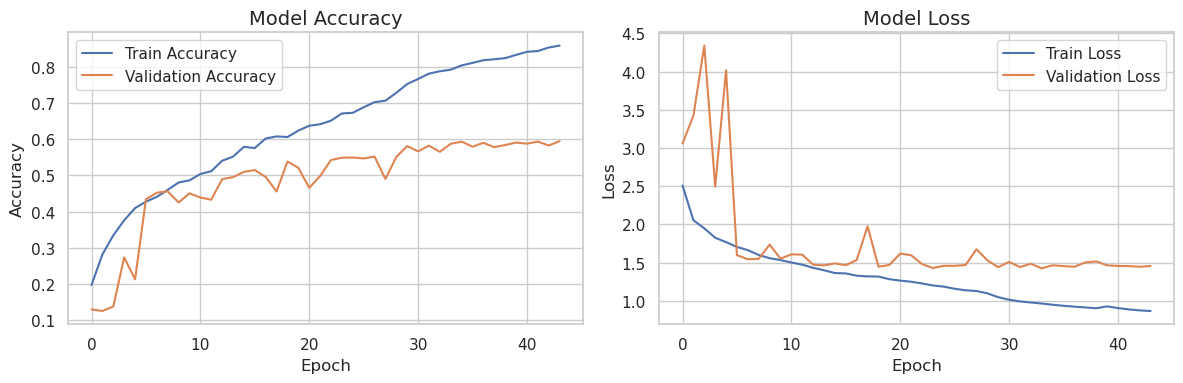

In [47]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png', dpi=300, bbox_inches='tight')
plt.show()